Copyright (c) 2017 Andrew Johnson, Dan Kotlyar, GTRC

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Results Reader

##  Basic operations

This notebook demonstrates the capabilities of the serpentTools to read Serpent results files. SERPENT [1] produces a result file (i.e. _res.m), containing general results (e.g. k-eff), metadata (e.g. title) and homogenized cross-sections. The homogenized cross-section sets are printed in the results file for all the requested universes. The ResultsReader is capable of reading this file, and storing the data inside univ objects. Each such object has methods and attributes that should ease analysis.

In [1]:
%matplotlib notebook
import numpy as np
import serpentTools
from serpentTools.settings import rc

In [2]:
rc.keys()

dict_keys(['depletion.metadataKeys', 'depletion.materialVariables', 'depletion.materials', 'depletion.processTotal', 'verbosity', 'serpentVersion', 'xs.variableGroups', 'xs.variableExtras'])

In [3]:
%time
resFile = 'InnerAssembly_res.m'
res = serpentTools.read(resFile)

Wall time: 0 ns


# Metadata

metadata is a collective data that describe the problem.
The following data is included: titles, data paths, and other descriptive data exist on the reader 

In [4]:
print(res.metadata['version'])  # Serpent version used for the execution
print(res.metadata['decayDataFilePath'])  # Directory path for data libraries
print(res.metadata['inputFileName'])  # Directory path for data libraries

Serpent 2.1.30
/nv/hp22/dkotlyar6/data/Codes/DATA/endfb7/sss_endfb7.dec
InnerAssembly


Obtain all the variables in the metadata through '.keys()'

In [5]:
res.metadata.keys()

dict_keys(['version', 'compileDate', 'debug', 'title', 'confidentialData', 'inputFileName', 'workingDirectory', 'hostname', 'cpuType', 'cpuMhz', 'startDate', 'completeDate', 'pop', 'cycles', 'skip', 'batchInterval', 'srcNormMode', 'seed', 'ufsMode', 'ufsOrder', 'neutronTransportMode', 'photonTransportMode', 'groupConstantGeneration', 'b1Calculation', 'b1BurnupCorrection', 'implicitReactionRates', 'optimizationMode', 'reconstructMicroxs', 'reconstructMacroxs', 'doubleIndexing', 'mgMajorantMode', 'spectrumCollapse', 'mpiTasks', 'ompThreads', 'mpiReproducibility', 'ompReproducibility', 'ompHistoryProfile', 'shareBufArray', 'shareRes2Array', 'xsDataFilePath', 'decayDataFilePath', 'sfyDataFilePath', 'nfyDataFilePath', 'braDataFilePath'])

In [6]:
# Grep the value of a certain key, e.g. simulation start date
res.metadata['startDate']

'Sat Apr 28 06:09:54 2018'

In [7]:
# statistics used for the execution (histories, inactive and active cycles)
print(res.metadata['pop'], res.metadata['skip']  , res.metadata['cycles'])

[ 5000.] [ 10.] [ 50.]


In [8]:
# Obtain the version defined in the settings
print('User defined version: {}'.format(rc['serpentVersion']))
# Obtain the version actually used in the execution
print('Used version: {}'.format(res.metadata['version']))

User defined version: 2.1.29
Used version: Serpent 2.1.30


Check if the used defined version and the utilized Serpent version match

In [9]:
# Compare
rc['serpentVersion'] in res.metadata['version']

False

# Results Data (resdata)

Results are stored as a function of time/burnup/index and include integral parameters of the system.
Results, such as k-eff, total flux, execution times are included in .resdata. Some results include values and uncertainities (e.g. criticality) and some just the values (e.g. CPU resources). 

In [10]:
# All the variables can be obtained by using 'resdata.keys()'
AllVariables = res.resdata.keys() # contains all the variable as a dict_keys
# The example below shows only the first five variables in the resdata dictionary
list(AllVariables)[0:5]

['minMacroxs', 'dtThresh', 'stFrac', 'dtFrac', 'dtEff']

In [11]:
# Time-dependent variables, such as k-eff, are stored in 'resdata'
print(res.resdata['absKeff'])  # Values (1st col.) + std (2nd col.) 

[[  1.29160000e+00   9.00000000e-04]
 [  1.29500000e+00   9.30000000e-04]
 [  1.29172000e+00   9.10000000e-04]
 [  1.29172000e+00   7.80000000e-04]
 [  1.29312000e+00   6.80000000e-04]
 [  1.29140000e+00   7.80000000e-04]]


In [12]:
# Obtain only the values for 'absKeff'
res.resdata['absKeff'][:,0]

array([ 1.2916 ,  1.295  ,  1.29172,  1.29172,  1.29312,  1.2914 ])

In [13]:
# Obtain only the uncertainties for 'absKeff'
res.resdata['absKeff'][:,1]

array([ 0.0009 ,  0.00093,  0.00091,  0.00078,  0.00068,  0.00078])

In [14]:
# Burnup data is not written by default, a burnup mode is defined within the input file
# Extract burnup related quantities
print(res.resdata['burnup']) # burnup intervals (MWd/kg) 
print(res.resdata['burnDays']) # time points (days)

[[ 0.        0.      ]
 [ 0.1       0.100001]
 [ 1.        1.00001 ]
 [ 2.        2.00001 ]
 [ 3.        3.00003 ]
 [ 4.        4.00004 ]]
[[  0.     ]
 [  1.20048]
 [ 12.0048 ]
 [ 24.0096 ]
 [ 36.0144 ]
 [ 48.0192 ]]


In [15]:
# Some variables are stored with no uncertainties
print(res.resdata['totCpuTime']) # total CPU time,  

[[ 10.814 ]
 [ 20.3573]
 [ 30.0783]
 [ 39.4965]
 [ 48.919 ]
 [ 58.6448]]


## Plotting resdata

Basic 1-D plotting capabilities are not yet avaialble in the parser. Plotting capability is planned to be added in the near-term. 

<IPython.core.display.Javascript object>


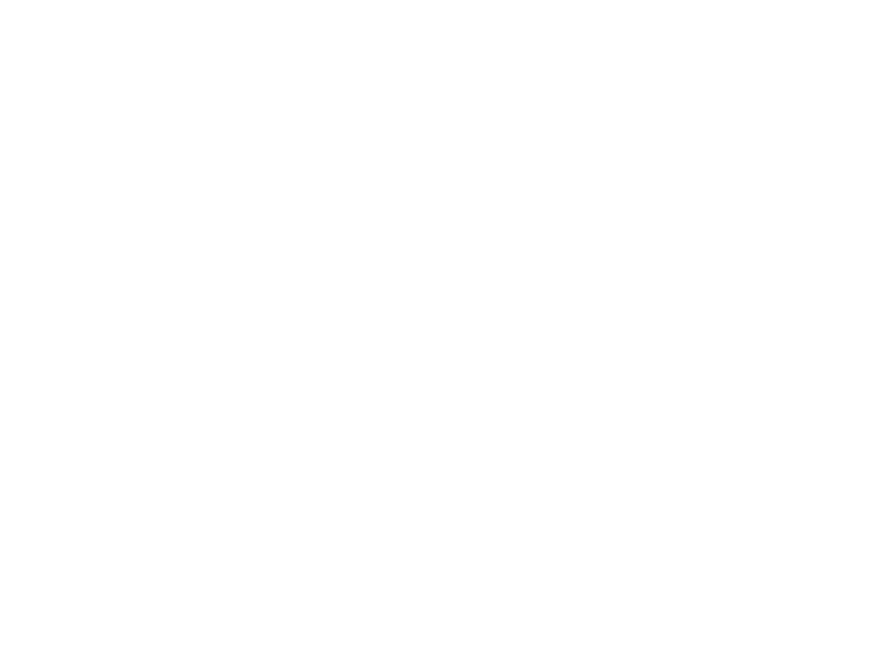

(<matplotlib.text.Text at 0x1fd537ad9b0>,
 <matplotlib.text.Text at 0x1fd538c3e10>)

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt
xdata = res.resdata['burnDays'][:] # obtain the time in (days)
ydata = res.resdata['absKeff'][:,0] # obtain the k-eff (values only)
plt.plot(xdata, ydata)
plt.xlabel('Time, days'), plt.ylabel('k-eff')               

# Universe Data (univdata)

Universe data is stored for each state point, i.e. ('univ',burnup, burnupIdx, time)
'univ': universe ID (e.g., '0'), burnup: in MWd/kg, burnupIdx: step index, time: in days.  
Results, such as infinite cross-sections, b1-leakage corrected cross-sections, kinetic parameters, are included in .univdata. All the results include values and uncertainties. 

In [17]:
# The different states are obtained by:
res.univdata.keys()
# The below cell presents the various unique states ('univ',burnup, burnupIdx, time)

dict_keys([('3101', 0.0, 1, 0.0), ('3102', 0.0, 1, 0.0), ('0', 0.0, 1, 0.0), ('3101', 0.10000000000000001, 2, 1.20048), ('3102', 0.10000000000000001, 2, 1.20048), ('0', 0.10000000000000001, 2, 1.20048), ('3101', 1.0, 3, 12.004799999999999), ('3102', 1.0, 3, 12.004799999999999), ('0', 1.0, 3, 12.004799999999999), ('3101', 2.0, 4, 24.009599999999999), ('3102', 2.0, 4, 24.009599999999999), ('0', 2.0, 4, 24.009599999999999), ('3101', 3.0, 5, 36.014400000000002), ('3102', 3.0, 5, 36.014400000000002), ('0', 3.0, 5, 36.014400000000002), ('3101', 4.0, 6, 48.019199999999998), ('3102', 4.0, 6, 48.019199999999998), ('0', 4.0, 6, 48.019199999999998)])

In [18]:
# Let's use the following unique state
print(res.univdata[('3102', 0.0, 1, 0.0)])

<HomogUniv 3102: burnup: 0.000 MWd/kgu, step: 1, 0.000 days>


Each state contains the same data fields, which can be obatined by using a specific state point: 

.infExp: infinite values, e.g. INF_ABS, 

.infUnc: infinite uncertainties, 

.b1Exp:  b1 (leakage corrected) values, e.g. B1_ABS,  

.b1Exp:  b1 (leakage corrected) uncertainties, 

.metadata: variables that don't include 'B1_' or 'INF_' prefixes, e.g. BETA

http://serpent-tools.readthedocs.io/en/latest/api/containers.html

In [19]:
# The parser reads all the variables by default
# Each field is a dictionary, with variables as keys and corresponding values.
res.univdata[('3102', 0.0, 1, 0.0)].infExp.keys() # obtain all the variables stored in 'infExp' field

dict_keys(['infMicroFlx', 'infKinf', 'infFlx', 'infFissFlx', 'infTot', 'infCapt', 'infAbs', 'infFiss', 'infNsf', 'infNubar', 'infKappa', 'infInvv', 'infScatt0', 'infScatt1', 'infScatt2', 'infScatt3', 'infScatt4', 'infScatt5', 'infScatt6', 'infScatt7', 'infScattp0', 'infScattp1', 'infScattp2', 'infScattp3', 'infScattp4', 'infScattp5', 'infScattp6', 'infScattp7', 'infTranspxs', 'infDiffcoef', 'infRabsxs', 'infRemxs', 'infI135Yield', 'infXe135Yield', 'infPm147Yield', 'infPm148Yield', 'infPm148mYield', 'infPm149Yield', 'infSm149Yield', 'infI135MicroAbs', 'infXe135MicroAbs', 'infPm147MicroAbs', 'infPm148MicroAbs', 'infPm148mMicroAbs', 'infPm149MicroAbs', 'infSm149MicroAbs', 'infXe135MacroAbs', 'infSm149MacroAbs', 'infChit', 'infChip', 'infChid', 'infS0', 'infS1', 'infS2', 'infS3', 'infS4', 'infS5', 'infS6', 'infS7', 'infSp0', 'infSp1', 'infSp2', 'infSp3', 'infSp4', 'infSp5', 'infSp6', 'infSp7'])

In [20]:
# The values are all energy dependent 
res.univdata[('3102', 0.0, 1, 0.0)].infExp['infAbs'] # obtain the infinite macroscopic xs for ('3102', 0.0, 1, 0.0)

array([ 0.0165899 ,  0.0129328 ,  0.00762619,  0.00763948,  0.00698894,
        0.0040974 ,  0.00335547,  0.00296838,  0.00307955,  0.00336124,
        0.00403117,  0.00505814,  0.00650752,  0.00736739,  0.00900915,
        0.0112762 ,  0.0127016 ,  0.0163994 ,  0.0181052 ,  0.0264999 ,
        0.028233  ,  0.0347882 ,  0.0452278 ,  0.119694  ])

In [21]:
# Obtain the infinite flux for ('3102', 0.0, 1, 0.0)
res.univdata[('3102', 0.0, 1, 0.0)].infExp['infFlx']

array([  2.61805000e+14,   4.26088000e+15,   1.92693000e+16,
         4.32718000e+16,   7.21572000e+16,   1.14643000e+17,
         2.01901000e+17,   2.93699000e+17,   2.93888000e+17,
         3.17757000e+17,   2.59040000e+17,   1.89472000e+17,
         1.24216000e+17,   1.47176000e+17,   7.08909000e+16,
         2.93442000e+16,   2.01286000e+16,   5.63901000e+15,
         1.61268000e+16,   6.98219000e+15,   2.27403000e+15,
         4.31891000e+14,   2.32016000e+14,   7.69489000e+12])

In [22]:
# Uncertainties can be obtained in a similar was by using the 'infUnc' field. 
# The variables will be identical to those defined in 'infExp'
res.univdata[('3102', 0.0, 1, 0.0)].infUnc['infFlx'] # obtain the relative uncertainty

array([ 0.0955 ,  0.03552,  0.0188 ,  0.0203 ,  0.00056,  0.00421,
        0.0005 ,  0.00054,  0.0026 ,  0.00093,  0.00383,  0.00402,
        0.00102,  0.00244,  0.00839,  0.01016,  0.01543,  0.00469,
        0.00339,  0.00472,  0.03833,  0.05035,  0.21903,  0.01531])

Serpent also outputs the 'B1' cross-sections. However, the user must enable the 'B1' option by setting the 'fum' card:
http://serpent.vtt.fi/mediawiki/index.php/Input_syntax_manual#set_fum

If this card is not enabled by the user, the 'B1_' variables will be zeros. 

In [23]:
# The parser reads all the variables by default
# Each field is a dictionary, with variables as keys and corresponding values.
res.univdata[('3102', 0.0, 1, 0.0)].b1Exp.keys() # obtain all the variables stored in 'b1Exp' field

dict_keys(['b1MicroFlx', 'b1Kinf', 'b1Keff', 'b1B2', 'b1Err', 'b1Flx', 'b1FissFlx', 'b1Tot', 'b1Capt', 'b1Abs', 'b1Fiss', 'b1Nsf', 'b1Nubar', 'b1Kappa', 'b1Invv', 'b1Scatt0', 'b1Scatt1', 'b1Scatt2', 'b1Scatt3', 'b1Scatt4', 'b1Scatt5', 'b1Scatt6', 'b1Scatt7', 'b1Scattp0', 'b1Scattp1', 'b1Scattp2', 'b1Scattp3', 'b1Scattp4', 'b1Scattp5', 'b1Scattp6', 'b1Scattp7', 'b1Transpxs', 'b1Diffcoef', 'b1Rabsxs', 'b1Remxs', 'b1I135Yield', 'b1Xe135Yield', 'b1Pm147Yield', 'b1Pm148Yield', 'b1Pm148mYield', 'b1Pm149Yield', 'b1Sm149Yield', 'b1I135MicroAbs', 'b1Xe135MicroAbs', 'b1Pm147MicroAbs', 'b1Pm148MicroAbs', 'b1Pm148mMicroAbs', 'b1Pm149MicroAbs', 'b1Sm149MicroAbs', 'b1Xe135MacroAbs', 'b1Sm149MacroAbs', 'b1Chit', 'b1Chip', 'b1Chid', 'b1S0', 'b1S1', 'b1S2', 'b1S3', 'b1S4', 'b1S5', 'b1S6', 'b1S7', 'b1Sp0', 'b1Sp1', 'b1Sp2', 'b1Sp3', 'b1Sp4', 'b1Sp5', 'b1Sp6', 'b1Sp7'])

In [24]:
# Obtain the b1 fluxes for ('3102', 0.0, 1, 0.0)
res.univdata[('3102', 0.0, 1, 0.0)].b1Exp['b1Flx']

array([  3.27148000e+14,   5.30393000e+15,   2.50108000e+16,
         5.47441000e+16,   9.13280000e+16,   1.40456000e+17,
         2.34361000e+17,   3.21272000e+17,   3.02647000e+17,
         3.11350000e+17,   2.40836000e+17,   1.68376000e+17,
         1.06617000e+17,   1.17665000e+17,   5.39391000e+16,
         2.18182000e+16,   1.48560000e+16,   4.08848000e+15,
         1.14579000e+16,   4.68890000e+15,   1.47869000e+15,
         3.00094000e+14,   1.42533000e+14,   6.60096000e+12])

In [25]:
# Obtain the b1 fluxes for ('3102', 0.0, 1, 0.0)
res.univdata[('3102', 0.0, 1, 0.0)].b1Exp['b1Abs']

array([ 0.0165899 ,  0.0129456 ,  0.00762701,  0.00764271,  0.00699916,
        0.00409948,  0.0033592 ,  0.00296877,  0.00307913,  0.00335933,
        0.00402806,  0.00505541,  0.00650378,  0.00735912,  0.00900474,
        0.011274  ,  0.0126918 ,  0.016395  ,  0.0181206 ,  0.0264826 ,
        0.0281695 ,  0.0356849 ,  0.0449217 ,  0.119694  ])

Data that does not contain the prefix 'INF_' or 'B1_' is stored under the 'metadata' field. 

Energy bins, kinetic, adjoint and other variables are stored under this field.  

In [26]:
res.univdata[('3102', 0.0, 1, 0.0)].metadata.keys() # obtain all the variables stored in 'metadata' field

dict_keys(['microNg', 'microE', 'macroNg', 'macroE', 'cmmTranspxs', 'cmmTranspxsX', 'cmmTranspxsY', 'cmmTranspxsZ', 'cmmDiffcoef', 'cmmDiffcoefX', 'cmmDiffcoefY', 'cmmDiffcoefZ', 'betaEff', 'lambda'])

In [27]:
# The data included in the 'metadata' field contains only the values (no uncertainties)
res.univdata[('3102', 0.0, 1, 0.0)].metadata['betaEff'] # obtain beta-effective

array([  3.20037000e-03,   9.06000000e-02,   2.90161000e-05,
         7.48490000e-01,   6.83225000e-04,   1.95500000e-01,
         5.11801000e-04,   1.66500000e-01,   1.13066000e-03,
         1.44010000e-01,   6.74450000e-04,   1.99150000e-01,
         1.71222000e-04,   3.58340000e-01])

In [28]:
# Obtain the macro energy structure in MeV
res.univdata[('3102', 0.0, 1, 0.0)].metadata['macroE']

array([  1.00000000e+37,   1.00000000e+01,   6.06530000e+00,
         3.67880000e+00,   2.23130000e+00,   1.35340000e+00,
         8.20850000e-01,   4.97870000e-01,   3.01970000e-01,
         1.83160000e-01,   1.11090000e-01,   6.73800000e-02,
         4.08680000e-02,   2.47880000e-02,   1.50340000e-02,
         9.11880000e-03,   5.53090000e-03,   3.35460000e-03,
         2.03470000e-03,   1.23410000e-03,   7.48520000e-04,
         4.54000000e-04,   3.12030000e-04,   1.48940000e-04,
         0.00000000e+00])

## Plotting univdata

In [29]:
# obtain the energy grid in descending order (high to low energy)
xdata = res.univdata[('3102', 0.0, 1, 0.0)].metadata['macroE'][1:] 
# obtain the inifinite abs. xs
ydataInf = res.univdata[('3102', 0.0, 1, 0.0)].infExp['infAbs']
ydataB1 = res.univdata[('3102', 0.0, 1, 0.0)].b1Exp['b1Abs']

In [30]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(xdata, ydataInf,'r', label='INF')
plt.plot(xdata, ydataB1,'*g', label='B1')
plt.legend()
plt.xlabel('Energy, MeV'), plt.ylabel('Macroscopic absorption cross section, cm$^{-1}$')  

<IPython.core.display.Javascript object>

(<matplotlib.text.Text at 0x1fd53a7c390>,
 <matplotlib.text.Text at 0x1fd53a867f0>)

##  Settings operations

The user is able to filter the required information by using the settings option.

A detailed description on how to use the settings can be found on:
http://serpent-tools.readthedocs.io/en/latest/api/settings.html

In [31]:
# Obtain the user defined keys
rc.keys()

dict_keys(['depletion.metadataKeys', 'depletion.materialVariables', 'depletion.materials', 'depletion.processTotal', 'verbosity', 'serpentVersion', 'xs.variableGroups', 'xs.variableExtras'])

In [32]:
# Change the serpent version to 2.1.29
import serpentTools
from serpentTools.settings import rc
rc['serpentVersion'] = '2.1.30'

KeyError: "Setting serpentVersion is\n2.1.30\nand not one of the allowed options:\n['2.1.29']"

In [ ]:
# Explicitly state which groups of variables should be stored
# The variables for these groups are defined according to the .yaml file
rc['xs.variableGroups'] = ['versions', 'gc-meta', 'xs', 'eig', 'burnup-coeff']

In [ ]:
# The user can state which cross-sections to store
rc['xs.getInfXS'] = True # Obtain the infinite xs
rc['xs.getB1XS'] = False # Do not store the leakage corrected xs